In [ ]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from collections import Counter
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
import gensim
import os, re, csv, math, codecs

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Embedding

## Tokenizador

In [ ]:
token=Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)
token.fit_on_texts(newsgroups_train.data)

In [ ]:
# Tokenizamos los textos y les fijamos la misma dimension
max_len=500

train_sequences=token.texts_to_sequences(newsgroups_train.data)
train_sequences=pad_sequences(train_sequences,maxlen=max_len)

test_sequences=token.texts_to_sequences(newsgroups_test.data)
test_sequences=pad_sequences(test_sequences,maxlen=max_len)

## Carga embeddings descargados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])

In [ ]:
#carga de embeddings externos
EMBEDDING_DIR = "/content/drive/My Drive/"
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 999995 word vectors


In [ ]:
#acomodamos la estructura de lso embeddings a gusto
embed_dim=300
num_words=len(dictionary)+1
embedding_matrix=np.zeros([num_words,embed_dim])
for word, idx in dictionary.items():
  if idx <= num_words and word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

# Embeddings + CNN + MLP

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dropout
from keras.models import Model
from keras import optimizers
from tensorflow.keras.utils import plot_model

In [ ]:
nb_words=num_words
num_filters=64
input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

conv8=Conv1D(num_filters, 8, activation='relu', padding='same')(embedding_layer)
pool8=GlobalMaxPooling1D()(conv8)
drop8 = Dropout(0.2)(pool8)

conv4=Conv1D(num_filters, 4, activation='relu', padding='same')(embedding_layer)
pool4=GlobalMaxPooling1D()(conv4)
drop4 = Dropout(0.2)(pool4)

conv3=Conv1D(num_filters, 3, activation='relu', padding='same')(embedding_layer)
pool3=GlobalMaxPooling1D()(conv3)
drop3 = Dropout(0.2)(pool3)

conv2=Conv1D(num_filters, 2, activation='relu', padding='same')(embedding_layer)
pool2=GlobalMaxPooling1D()(conv2)
drop2 = Dropout(0.2)(pool2)

added = Concatenate()([drop8, drop4, drop3, drop2])

dense1=Dense(32, activation='relu')(added)
dense2=Dense(20, activation='softmax')(dense1)

model=Model(input_layer , dense2)

adam = optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

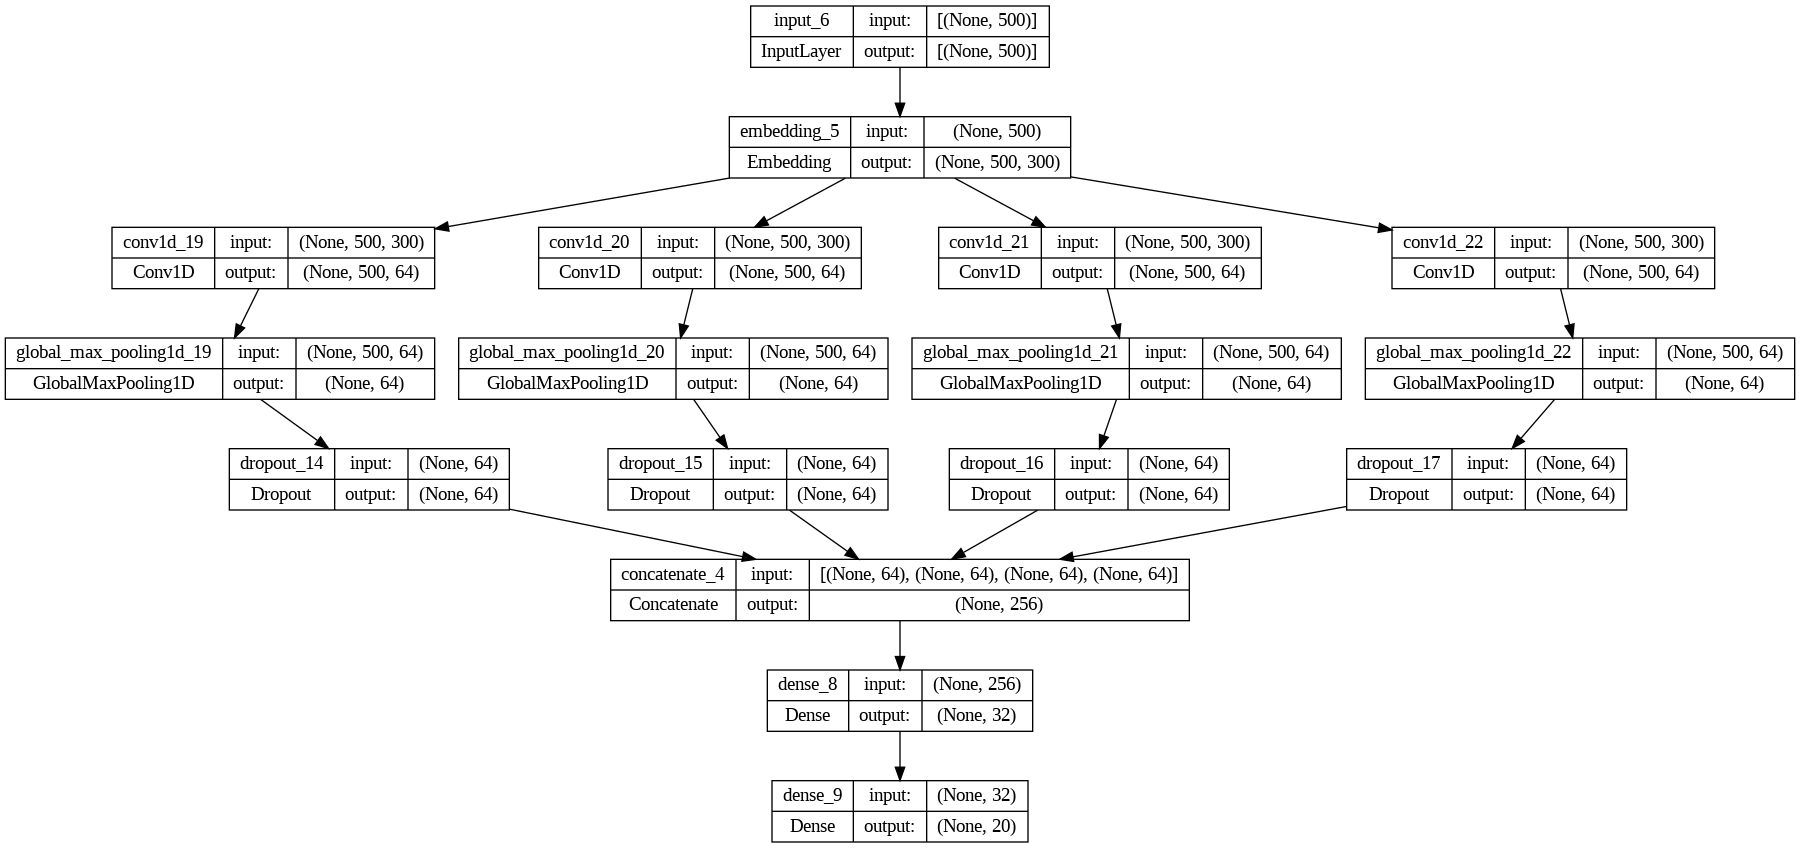

In [ ]:
plot_model(model, "CNN.png", show_shapes=True)

In [ ]:
model.fit(train_sequences, newsgroups_train.target,batch_size=32,epochs=30,validation_split=0.2)

Epoch 1/30
283/283 [==============================] - 5s 16ms/step - loss: 0.0192 - accuracy: 0.9960 - val_loss: 0.4565 - val_accuracy: 0.8860
Epoch 2/30
283/283 [==============================] - 4s 15ms/step - loss: 0.0168 - accuracy: 0.9965 - val_loss: 0.4718 - val_accuracy: 0.8838
Epoch 3/30
283/283 [==============================] - 4s 16ms/step - loss: 0.0186 - accuracy: 0.9955 - val_loss: 0.4728 - val_accuracy: 0.8869
Epoch 4/30
283/283 [==============================] - 5s 16ms/step - loss: 0.0152 - accuracy: 0.9965 - val_loss: 0.5134 - val_accuracy: 0.8838
Epoch 5/30
283/283 [==============================] - 4s 16ms/step - loss: 0.0158 - accuracy: 0.9967 - val_loss: 0.4676 - val_accuracy: 0.8895
Epoch 6/30
283/283 [==============================] - 4s 16ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.5210 - val_accuracy: 0.8860
Epoch 7/30
283/283 [==============================] - 5s 17ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.5086 - val_accuracy: 0.8895

##Conclusiones
Al agregar una rama convolucional más previo a la etapa MLP podemos ver que la red es capaz de reconocer patrones en secuencias de palabras más largas, lo cual en esta aplicación no genera mejoras sublimes en los resultados pero para otras tareas como prediccion de textos sí podria serlo.

Agregar Dropout entre ramas de convolucionales ayudó a mejorar el entrenamiento de cada rama por separado y así lograr este diferencial en la performance.

# biDir + XXXXXXXX

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from keras.layers import Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda
from keras.layers import Bidirectional, LSTM, Activation, Reshape
import keras.backend as K
from keras.activations import softmax
from keras.models import Model
from keras import optimizers
value_dim=100

In [ ]:
def softMaxOverTime(x):
    return softmax(x,axis=1)

nb_words=num_words
num_filters=64
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True,activation="relu"),merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention=Reshape([max_len,value_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1=Dense(32, activation='relu')(embedding_sum)
dense2=Dense(20, activation='softmax')(dense1)

model=Model(input_layer , dense2)
adam = optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


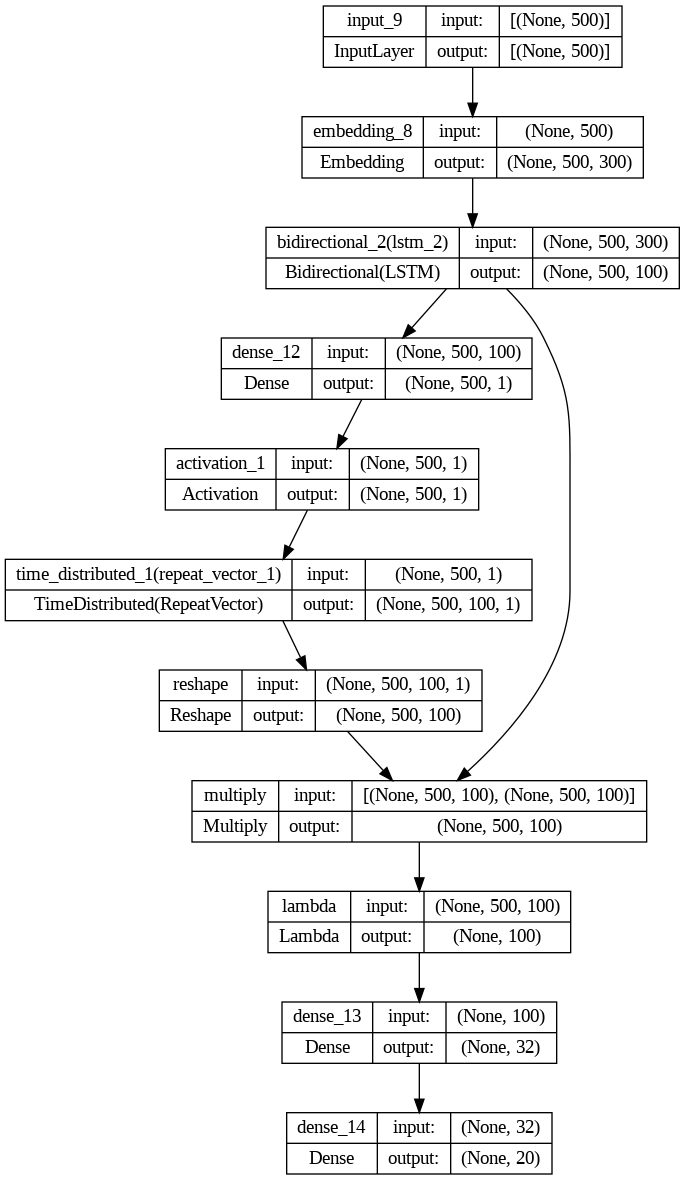

In [ ]:
plot_model(model, "Bidir.png", show_shapes=True)

In [ ]:
model.fit(train_sequences, newsgroups_train.target,batch_size=256,epochs=50,validation_split=0.2)

Epoch 1/50
36/36 [==============================] - 59s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 2/50
36/36 [==============================] - 61s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 3/50
36/36 [==============================] - 60s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 4/50
36/36 [==============================] - 59s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 5/50
36/36 [==============================] - 60s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 6/50
36/36 [==============================] - 59s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 7/50
36/36 [==============================] - 59s 2s/step - loss: nan - accuracy: 0.0418 - val_loss: nan - val_accuracy: 0.0451
Epoch 8/50
36/36 [==============================] - 60s 2s/ste

KeyboardInterrupt: ignored